In [4]:
# Changable Parameters

model_name = "convnext_tiny_test_NOSD"
model_cpt = model_name + "_1_1.tar"
DATASET_PATH = "data"
dataset_type = "atsds_large"
dataset_split = "test"

CHECKPOINT_PATH = "model/"



In [5]:
%load_ext autoreload
%autoreload 2


from ATSDS import ATSDS
import matplotlib.pyplot as plt

import torch
from torchvision import transforms as transforms
## Standard libraries
import os
import json
import math
import random
import numpy as np 
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
CUDA_LAUNCH_BLOCKING=1

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim


transform_test_crop = transforms.Compose(
    [transforms.Resize(256),
    transforms.CenterCrop(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


transform_test = transforms.Compose(
    [transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


def load_model(model,optimizer,scheduler,filepath):
    cpt = torch.load(filepath,map_location=torch.device('cpu'))
    model.load_state_dict(cpt['model'])
    optimizer.load_state_dict(cpt['optimizer'])
    scheduler.load_state_dict(cpt['scheduler'])
    return cpt['epoch'], cpt['trainstats']
    
RANDOM_SEED = 1414

torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Used for reproducability to fix randomness in some GPU calculations
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device cuda:0


In [6]:
testset = ATSDS(root=DATASET_PATH, split=dataset_split, dataset_type=dataset_type, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size = 1, shuffle = True, num_workers = 2)
import torchvision
print(torchvision.__file__)

data\atsds_large\test
C:\Users\Julia\anaconda3\envs\lib\site-packages\torchvision\__init__.py


In [7]:
from model import get_model

model = get_model(model_name, n_classes = testset.get_num_classes())
model = model.to(device)
model.eval()
loss_criterion = nn.CrossEntropyLoss()

loss_criterion = loss_criterion.to(device)
optimizer = optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,200)
running_loss = 0
total = 0
correct = 0
save_osc = 1
epoch = 0
trainloss = []
trainacc = []


C:\Users\Julia\anaconda3\envs\lib\site-packages\torchvision\ops\misc.py:120: UserWarning: Don't use ConvNormActivation directly, please use Conv2dNormActivation and Conv3dNormActivation instead.
  warnings.warn(


In [8]:
epoch,trainstats = load_model(model, optimizer, scheduler, "model/" + model_cpt)
train_loss = trainstats[0]
test_loss = trainstats[1]
detailed_stats = trainstats[2]


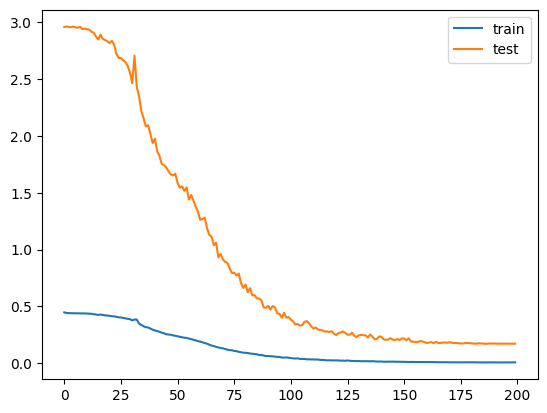

In [9]:
plt.plot(np.divide(train_loss,450), label = "train")
plt.plot(test_loss, label = "test")
plt.legend()

In [10]:
IMAGES_PATH = 'data/' + dataset_type + '/' + dataset_split + '/'
# Define our Categories
CATEGORIES = sorted(os.listdir(IMAGES_PATH))
class_to_dataset_class_dict = {}
for cat in CATEGORIES:
    class_to_dataset_class_dict[cat] = cat
label_idx_dict = {}
for count,cat in enumerate(CATEGORIES):
    label_idx_dict[cat] = count

imagedict = {}
for cat in CATEGORIES:
    imagedict[cat] = []
    imagelist = os.listdir(IMAGES_PATH + cat + "/")
    for im in imagelist:
        imagedict[cat].append(im)            
output_types = ["mask","mask_on_image"]     


In [11]:
import cv2


# Let's import what we need for gradcam and our visualizations
# Import Gradcam - Check the gradcam.py for the code.
from gradcam import get_gradcam

# Returns the Image with the Mask as overlay.
def mask_on_image(mask,img,alpha=0.5):
    heatmap = get_rgb_heatmap(mask)
    img = img.squeeze()
    cam_on_img = (1-alpha)*img + alpha*heatmap
    return np.copy(cam_on_img)

def get_rgb_heatmap(mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255
    return np.copy(heatmap)

#get a cutout based on a cutoff value
def get_cutoff_area(mask,img,cutoff = 0.5):
    for i in range(3):
        img[:,:,i] = np.where(mask>cutoff,img[:,:,i],0)
    return np.copy(img)

#get a cutout based on a percentage value.
def get_percentage_of_image(image,mask,percentage):
    masked_image = np.zeros_like(image)
    n = mask.size
    sortedvalues = np.sort(mask.flatten('K'))[::-1]
    
    index = int(n/100*percentage)
    index_2 = n//100*percentage
    cutoff = sortedvalues[index]
    for i in range(3):
        masked_image[:,:,i] = np.where(mask-cutoff>0,image[:,:,i],0)
    return masked_image

def normalize_image(img):
    return np.nan_to_num((img-img.min())/(img.max()-img.min()))

def get_input_tensors(image):
    return transform_test(image).unsqueeze(0)

In [12]:
print(model) # confirm gradcam layer if necessary
#GRADCAM_TARGET_LAYER = model.conv3 # Simple CNN
GRADCAM_TARGET_LAYER = model.features[-1][-1].block[0] # convnext
#GRADCAM_TARGET_LAYER = model.features[-3] # VGG
#GRADCAM_TARGET_LAYER = model.layer4[-1].conv3 # resnet50
print(GRADCAM_TARGET_LAYER)

ConvNeXt(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU()
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384

In [13]:
# Make sure the Output_path exists.
# Define what percentage cutouts you want. 
# If you are only interested in the masks you can just make this an empty list []

import matplotlib.image
from PIL import Image

IMAGES_PATH = 'data/' + dataset_type + '/' + dataset_split + '/'
IMAGES_SUFFIX = '.png'
output_path = 'data/auswertung/' + model_name + "/" + "gradcam/" + dataset_split + "/"

# This creates the needed folders inside. As mentioned above the Folder defined in output_path has to already exist


#if ('gradmask' not in os.listdir(output_path)):
#    os.makedirs(output_path + 'gradmask')   
#if ('mask_on_image' not in os.listdir(output_path)):
#    os.makedirs(output_path + 'mask_on_image')   


#for pct in SHOWN_PERCENTAGE:
#    if ('percentage_' + str(pct) not in os.listdir(output_path)):
#        os.makedirs(output_path + 'percentage_' + str(pct))   
#    if ('cutout' not in os.listdir(output_path + 'percentage_' + str(pct))):
#        os.makedirs(output_path + 'percentage_' + str(pct) + '/cutout')   
#    if ('mask' not in os.listdir(output_path + 'percentage_' + str(pct))):
#        os.makedirs(output_path + 'percentage_' + str(pct) + '/mask')   

if not os.path.isdir(output_path):
    os.makedirs(output_path)

for cat in CATEGORIES:
    for outputs in output_types:
        if not os.path.isdir(output_path + cat + "/" + outputs):
            os.makedirs(output_path + cat + "/" + outputs)

In [14]:
for cat in class_to_dataset_class_dict:
    model.eval()
    images = imagedict[cat]
    for imagename in images:
        with open(os.path.abspath(IMAGES_PATH + cat + "/" + imagename), 'rb') as f:
            with Image.open(f) as current_image:
                current_image_tensor = get_input_tensors(current_image)
                #print(imagename, class_to_dataset_class_dict[image_class])
            # These values are only used for the example pictures, the pipeline values are below them.
            current_image_tensor = current_image_tensor.cuda()
            shape = (np.array(current_image).shape[0],np.array(current_image).shape[1])
            original_mask, _ = get_gradcam(model,GRADCAM_TARGET_LAYER,current_image_tensor,label_idx_dict[class_to_dataset_class_dict[cat]],shape)
            image = np.copy(current_image)
            mask = np.copy(original_mask)
            np.save(output_path + cat +  "/mask/" + imagename, mask)
            overlay_image = (mask_on_image(normalize_image(mask),normalize_image(image),alpha=0.3)*255).astype(np.uint8)
            save_overlay_image = Image.fromarray(overlay_image)
            save_overlay_image.save(output_path + cat + "/mask_on_image/" + imagename, "PNG")

C:\Users\Julia\anaconda3\envs\lib\site-packages\torch\nn\modules\module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_23088\783136648.py:41: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num((img-img.min())/(img.max()-img.min()))


In [29]:
from lime import lime_image
explainer = lime_image.LimeImageExplainer()


In [30]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()


In [31]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()


In [32]:
from skimage.segmentation import mark_boundaries


In [33]:
# Make sure the Output_path exists.
# Define what percentage cutouts you want. 
# If you are only interested in the masks you can just make this an empty list []

import matplotlib.image
from PIL import Image

output_path = 'data/auswertung/' + model_name + "/" + "lime/" + dataset_split + "/"

# This creates the needed folders inside. As mentioned above the Folder defined in output_path has to already exist
for cat in CATEGORIES:
    for outputs in output_types:
        if not os.path.isdir(output_path + cat + "/" + outputs):
            os.makedirs(output_path + cat + "/" + outputs)

In [34]:
for cat in class_to_dataset_class_dict:
    images = imagedict[cat]
    for imagename in images:
        with open(os.path.abspath(IMAGES_PATH + cat + "/" + imagename), 'rb') as f:
            with Image.open(f) as current_image:
                current_image_tensor = get_input_tensors(current_image)
                #print(imagename, class_to_dataset_class_dict[image_class])
            # These values are only used for the example pictures, the pipeline values are below them.
                #print(imagename, class_to_dataset_class_dict[image_class])
            # These values are only used for the example pictures, the pipeline values are below them.
            current_image_tensor = current_image_tensor.cuda()
            shape = (np.array(current_image).shape[0],np.array(current_image).shape[1])
            explanation = explainer.explain_instance(np.array(pill_transf(current_image)), 
                                         batch_predict, # classification function
                                         top_labels=20, 
                                         hide_color=0, 
                                         num_samples=100) # number of images that will be sent to classification function
            temp , mask_raw = explanation.get_image_and_mask(label_idx_dict[cat], positive_only=False, num_features=1, hide_rest=False)
            img_boundry = mark_boundaries(temp, mask_raw)
            save_moi = Image.fromarray((img_boundry*255).astype(np.uint8))
            save_moi.save(output_path + cat + '/mask_on_image/' + imagename, "PNG")
            #save_mask = Image.fromarray((mask*255).astype(np.uint8))
            #save_mask.save(output_path + cat + '/mask/' + imagename, "PNG")
            mask = normalize_image(F.interpolate(torch.Tensor(mask_raw).reshape(1,1,224,224),(512,512),mode = "bilinear").squeeze().squeeze().numpy())

            np.save(output_path + cat + '/mask/' + imagename, mask)

            
            

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [35]:
# Make sure the Output_path exists.
# Define what percentage cutouts you want. 
# If you are only interested in the masks you can just make this an empty list []

import matplotlib.image
from PIL import Image

output_path = 'data/auswertung/' + model_name + "/" + "prism/" + dataset_split + "/"

# This creates the needed folders inside. As mentioned above the Folder defined in output_path has to already exist
for cat in CATEGORIES:
    for outputs in output_types:
        if not os.path.isdir(output_path + cat + "/" + outputs):
            os.makedirs(output_path + cat + "/" + outputs)

from torchprism import PRISM
PRISM.prune_old_hooks(model)
PRISM.register_hooks(model)


No hooks to remove


In [36]:
import torch
import os, glob
from torchvision import transforms
import matplotlib.pyplot as plt
import cv2

_crop = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224))
])
_normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def load_images():
    image_files = glob.glob("../samples/*.jpg")
    image_files.sort()

    input_images = [ cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB) for f in image_files ]
    input_batch = torch.stack([_normalize(_crop(image)) for image in input_images])

    return input_batch

def _normalize_image(image):
    # change image tensor from -1,1 to 0,1
    return (image - image.min()) / (image.max() - image.min())

def draw_input_n_prism(drawable_input_batch, drawable_prism_maps_batch):
    plt.title(f"PRISM")

    columns = drawable_input_batch.shape[0]
    fig, ax = plt.subplots(nrows=2, ncols=columns)
    if columns == 1:
        ax[0].imshow(_normalize_image(drawable_input_batch[0]))
        ax[0].axis('off')
        ax[1].imshow(drawable_prism_maps_batch[0])
        ax[1].axis('off')
    else:
        for column in range(columns):
            ax[0][column].imshow(_normalize_image(drawable_input_batch[column]))
            ax[0][column].axis('off')

        for column in range(columns):
            print(column)
            ax[1][column].imshow(drawable_prism_maps_batch[column])
            ax[1][column].axis('off')

    fig.tight_layout()
    plt.savefig(f"PRISM_result.png", format='png', bbox_inches="tight", dpi=500)

In [37]:
for cat in class_to_dataset_class_dict:
    images = imagedict[cat]
    for imagename in images:
        with open(os.path.abspath(IMAGES_PATH + cat + "/" + imagename), 'rb') as f:
            with Image.open(f) as current_image:
                current_image_tensor = get_input_tensors(current_image)
                #print(imagename, class_to_dataset_class_dict[image_class])
            # These values are only used for the example pictures, the pipeline values are below them.
            print(f)
            current_image_tensor = current_image_tensor.cuda()
            model(current_image_tensor)
            prism_maps = PRISM.get_maps()
            drawable_prism_maps = prism_maps.permute(0, 2, 3, 1).detach().cpu().numpy().squeeze()
            save_moi = Image.fromarray((drawable_prism_maps*255).astype(np.uint8))
            save_moi.save(output_path + cat + '/mask_on_image/' + imagename, "PNG")
            
            mask_raw = np.array(save_moi)
            mask_norm = (mask_raw - mask_raw.mean()) // mask_raw.std()
            mask_f = np.max(mask_norm,axis=2)
            print(mask_f.min(),mask_f.max())
            mask = normalize_image(F.interpolate(F.relu(torch.Tensor(mask_f)).reshape(1,1,224,224),(512,512),mode = "bilinear").squeeze().squeeze().numpy())
            #save_mask = Image.fromarray(mask_f*255).convert("L")
            #save_mask.save(output_path + cat + '/mask/' + imagename, "PNG")
            np.save(output_path + cat + '/mask/' + imagename, mask)

<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00001\\000000.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00001\\000001.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00001\\000002.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00001\\000003.png'>
-2.0 1.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00001\\000004.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00001\\000005.png'>
-3.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00001\\000006.png'>
-2.0 1.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00001\\000007.png'>
-1.0 3.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00001\\000008.png'>
-2.0 2.0
<_io.BufferedReader

-2.0 1.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00002\\000078.png'>
-2.0 1.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00002\\000079.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00002\\000080.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00002\\000081.png'>
-3.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00002\\000082.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00002\\000083.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00002\\000084.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00002\\000085.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00002\\000086.png'>
-2.0 2.0
<_io.Buffe

-2.0 3.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00004\\000155.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00004\\000156.png'>
-2.0 1.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00004\\000157.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00004\\000158.png'>
-2.0 1.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00004\\000159.png'>
-1.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00004\\000160.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00004\\000161.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00004\\000162.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00004\\000163.png'>
-2.0 2.0
<_io.Buffe

-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00005\\000233.png'>
-2.0 1.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00005\\000234.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00005\\000235.png'>
-1.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00005\\000236.png'>
-2.0 1.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00005\\000237.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00005\\000238.png'>
-2.0 1.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00005\\000239.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00005\\000240.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00005\\000241.png'>
-2.0 2.0
<_io.Buffe

-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00008\\000311.png'>
-2.0 1.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00008\\000312.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00008\\000313.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00008\\000314.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00008\\000315.png'>
-2.0 1.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00008\\000316.png'>
-3.0 3.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00008\\000317.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00008\\000318.png'>
-2.0 1.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00008\\000319.png'>
-2.0 2.0
<_io.Buffe

-3.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00009\\000389.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00009\\000390.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00009\\000391.png'>
-2.0 1.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00009\\000392.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00009\\000393.png'>
-2.0 1.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00009\\000394.png'>
-2.0 1.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00009\\000395.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00009\\000396.png'>
-2.0 1.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00009\\000397.png'>
-2.0 2.0
<_io.Buffe

-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00011\\000467.png'>
-2.0 1.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00011\\000468.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00011\\000469.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00011\\000470.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00011\\000471.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00011\\000472.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00011\\000473.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00011\\000474.png'>
-2.0 1.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00011\\000475.png'>
-2.0 1.0
<_io.Buffe

-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00012\\000545.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00012\\000546.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00012\\000547.png'>
-2.0 1.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00012\\000548.png'>
-2.0 1.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00012\\000549.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00013\\000550.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00013\\000551.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00013\\000552.png'>
-2.0 1.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00013\\000553.png'>
-2.0 1.0
<_io.Buffe

-2.0 1.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00014\\000623.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00014\\000624.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00014\\000625.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00014\\000626.png'>
-1.0 3.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00014\\000627.png'>
-2.0 1.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00014\\000628.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00014\\000629.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00014\\000630.png'>
-2.0 1.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00014\\000631.png'>
-2.0 2.0
<_io.Buffe

-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00018\\000701.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00018\\000702.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00018\\000703.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00018\\000704.png'>
-2.0 1.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00018\\000705.png'>
-1.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00018\\000706.png'>
-3.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00018\\000707.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00018\\000708.png'>
-2.0 1.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00018\\000709.png'>
-2.0 2.0
<_io.Buffe

-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00025\\000778.png'>
-2.0 1.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00025\\000779.png'>
-2.0 1.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00025\\000780.png'>
-2.0 1.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00025\\000781.png'>
-2.0 1.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00025\\000782.png'>
-3.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00025\\000783.png'>
-2.0 1.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00025\\000784.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00025\\000785.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00025\\000786.png'>
-2.0 2.0
<_io.Buffe

-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00035\\000856.png'>
-2.0 1.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00035\\000857.png'>
-3.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00035\\000858.png'>
-2.0 1.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00035\\000859.png'>
-2.0 1.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00035\\000860.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00035\\000861.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00035\\000862.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00035\\000863.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00035\\000864.png'>
-2.0 1.0
<_io.Buffe

-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00038\\000934.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00038\\000935.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00038\\000936.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00038\\000937.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00038\\000938.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00038\\000939.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00038\\000940.png'>
-3.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00038\\000941.png'>
-2.0 2.0
<_io.BufferedReader name='F:\\Uni\\Masterarbeit\\Code\\data\\atsds_large\\test\\00038\\000942.png'>
-2.0 2.0
<_io.Buffe

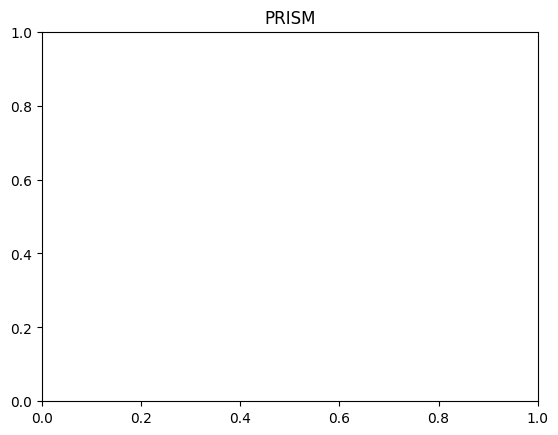

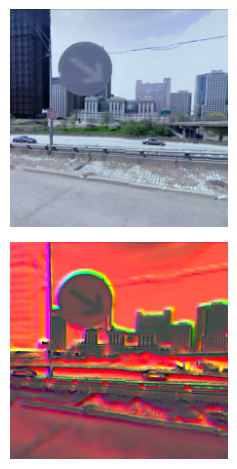

In [38]:
model(current_image_tensor)
prism_maps = PRISM.get_maps().detach().cpu()
draw_input_n_prism(current_image_tensor.cpu().permute(0, 2, 3, 1), prism_maps.permute(0, 2, 3, 1))


In [16]:
import saliency.core as saliency
import pickle
xrai_obj = saliency.XRAI()

output_path = 'data/auswertung/' + model_name + "/" + "xrai/" + dataset_split + "/"

for cat in CATEGORIES:
    for outputs in output_types:
        if not os.path.isdir(output_path + cat + "/" + outputs):
            os.makedirs(output_path + cat + "/" + outputs)


In [40]:
for cat in class_to_dataset_class_dict:
    images = imagedict[cat]
    for imagename in images:
        with open(os.path.abspath(IMAGES_PATH + cat + "/" + imagename), 'rb') as f:
            with Image.open(f) as current_image:
                current_image_tensor = transform_test(current_image)
                #print(imagename, class_to_dataset_class_dict[image_class])
            # These values are only used for the example pictures, the pipeline values are below them.
            file = open("data/auswertung/" + model_name + "/ig/test/" + cat + "/" +  imagename[:-4] + ".pkl", "rb")
            attribs = pickle.load(file)
            mask_raw = xrai_obj.GetMask(np.moveaxis(np.array(current_image_tensor),0,2),_,base_attribution = np.moveaxis(attribs,0,2))
            mask = normalize_image(F.interpolate(torch.Tensor(mask_raw).reshape(1,1,224,224),(512,512),mode = "bilinear").squeeze().squeeze().numpy())
            image = np.copy(current_image)
            #save_mask = Image.fromarray(mask*255).convert("L")
            #save_mask.save(output_path + cat +  "/mask/" + imagename, "PNG")
            np.save(output_path + cat +  "/mask/" + imagename,mask)
            overlay_image = (mask_on_image(normalize_image(mask),normalize_image(image),alpha=0.3)*255).astype(np.uint8)
            save_overlay_image = Image.fromarray(overlay_image)
            save_overlay_image.save(output_path + cat + "/mask_on_image/" + imagename, "PNG")

C:\Users\Julia\anaconda3\envs\lib\site-packages\saliency\core\xrai.py:126: FutureWarning: `selem` is a deprecated argument name for `dilation`. It will be removed in version 1.0. Please use `footprint` instead.
  masks = [dilation(mask, selem=selem) for mask in masks]


In [17]:
def create_gaussian_bell(res,radius=64,scale=1.21e-3,mu=0):
    """
    Creates a 2D Gaussian bell-shaped filter.

    Parameters:
    - res (int): The size of the image (width and height need to be the same).
    - radius (int): The radius of the bell-shaped filter.
    - scale (float): Scaling factor for the Gaussian function (default: 1.21e-3).
    - mu (float): Mean value for the Gaussian function (default: 0).

    Returns:
    numpy.ndarray: A 2D Gaussian bell-shaped filter.
    """

    xx, yy =  np.meshgrid(np.arange(-radius, radius+1), np.arange(-radius, radius+1))

    bell = np.exp(-((xx - mu)*(xx - mu)+(yy - mu)*(yy - mu))*scale)
    # since returned array is square shapes set all values outside the desired circle to 0
    for i in range(bell.shape[0]):
        for j in range(bell.shape[1]):
            if (np.sqrt((i-radius)**2+(j-radius)**2)>radius):
                bell[i][j]=0
    return bell


def add_gaussian_bell_to_image(img, x, y, weight, res, radius, bell):
    """
    Adds a precomputed Gaussian bell to a specific position on the image.

    Parameters:
    - img (numpy.ndarray): The input image.
    - x (int): The x-coordinate of the center of the bell.
    - y (int): The y-coordinate of the center of the bell.
    - weight (float): The weight of the bell.
    - res (int): The size of the filter (both width and height).
    - radius (int): The radius of the bell-shaped filter.
    - bell (numpy.ndarray): (see create_gaussian_bell).

    Raises:
    - AssertionError: If the specified position (x, y) is out of bounds.

    """
    
    assert 0 <= x < res
    assert 0 <= y < res
    
    # account for margin
    x += radius
    y += radius
    
    idx_x1 = x - radius
    idx_x2 = x + radius + 1
    
    idx_y1 = y - radius
    idx_y2 = y + radius + 1
    
    img[idx_x1:idx_x2, idx_y1: idx_y2] += bell*weight


def duration_distance_weighted_density_mask_gaussian(pixels,durations,size = (224,224),radius = 64,bell_scale=1.21e-3):
    """
    Creates a duration-distance-weighted density mask using Gaussian bells.

    Parameters:
    - pixels (list of tuples): List of pixel coordinates (x, y).
    - durations (list): List of durations corresponding to each pixel.
    - size (tuple): The size of the output mask (width, height) (default: (1024, 1024)).
    - radius (int): The radius of the Gaussian bell filter (default: 58).

    Returns:
    tuple: A tuple containing the density mask and the normalized version of the mask.

    Note:
    - The function assumes that the input pixel coordinates are within the specified size.

    """
    res = size[0]
    mask = np.zeros((res + 2 * radius, res + 2 * radius))
    bell = create_gaussian_bell(size[0], radius,bell_scale)
    
    for pixel, duration in zip(pixels, durations):
        add_gaussian_bell_to_image(mask, pixel[0], pixel[1], duration, res, radius, bell)
    
    mask = mask[radius:-radius, radius:-radius]
    normalized_mask = (mask - mask.min()) / (mask.max() - mask.min())
    
    return mask, normalized_mask

def ig_fixpoints(attributions,fixpoint_nums=256,scale = 1.20e-3):
    x,y = attributions.shape[1:3]
    ig_fix_mask = np.zeros_like(attributions)
    pixels = [(i,j) for i in range(x) for j in range(y)]
    weights = attributions.flatten()
    weighted_pixels = [(w,x) for w,x in zip(weights,pixels)]
    sorted_weighted_pixels = sorted(weighted_pixels)[::-1][:fixpoint_nums]
    w = [i for i, j in sorted_weighted_pixels]
    p = [j for i, j in sorted_weighted_pixels]

    ig_fix_mask = duration_distance_weighted_density_mask_gaussian(p,w,bell_scale=scale)
    return ig_fix_mask[1]


In [23]:
scale_current = 1.2e-3
fixpoint_nums_current = 64
output_path = 'data/auswertung/' + model_name + "/" + "ig_fixpoints_" + str(scale_current) + "_" + str(fixpoint_nums_current) +  "/" + dataset_split + "/"

for cat in CATEGORIES:
    for outputs in output_types:
        if not os.path.isdir(output_path + cat + "/" + outputs):
            os.makedirs(output_path + cat + "/" + outputs)

In [24]:
for cat in class_to_dataset_class_dict:
    images = imagedict[cat]
    for imagename in images:
        with open(os.path.abspath(IMAGES_PATH + cat + "/" + imagename), 'rb') as f:
            with Image.open(f) as current_image:
                current_image_tensor = transform_test(current_image)
                #print(imagename, class_to_dataset_class_dict[image_class])
            # These values are only used for the example pictures, the pipeline values are below them.
            file = open("data/auswertung/" + model_name + "/ig/test/" + cat + "/" +  imagename[:-4] + ".pkl", "rb")
            attribs = pickle.load(file)
            mask_raw = ig_fixpoints(attribs,fixpoint_nums=fixpoint_nums_current,scale = scale_current)
            mask = normalize_image(F.interpolate(torch.Tensor(mask_raw).reshape(1,1,224,224),(512,512),mode = "bilinear").squeeze().squeeze().numpy())
            image = np.copy(current_image)
            #save_mask = Image.fromarray(mask*255).convert("L")
            #save_mask.save(output_path + cat +  "/mask/" + imagename, "PNG")
            np.save(output_path + cat +  "/mask/" + imagename, mask)
            overlay_image = (mask_on_image(normalize_image(mask),normalize_image(image),alpha=0.3)*255).astype(np.uint8)
            save_overlay_image = Image.fromarray(overlay_image)
            save_overlay_image.save(output_path + cat + "/mask_on_image/" + imagename, "PNG")

In [123]:
output_path = 'data/auswertung/' + model_name + "/" + "ig_fixpoints_abs/" + dataset_split + "/"

for cat in CATEGORIES:
    for outputs in output_types:
        if not os.path.isdir(output_path + cat + "/" + outputs):
            os.makedirs(output_path + cat + "/" + outputs)

In [124]:
for cat in class_to_dataset_class_dict:
    images = imagedict[cat]
    for imagename in images:
        with open(os.path.abspath(IMAGES_PATH + cat + "/" + imagename), 'rb') as f:
            with Image.open(f) as current_image:
                current_image_tensor = transform_test(current_image)
                #print(imagename, class_to_dataset_class_dict[image_class])
            # These values are only used for the example pictures, the pipeline values are below them.
            file = open("data/auswertung/" + model_name + "/ig/test/" + cat + "/" +  imagename[:-4] + ".pkl", "rb")
            attribs = pickle.load(file)
            attribs = np.abs(attribs)
            mask_raw = ig_fixpoints(attribs,fixpoint_nums=128)
            mask = normalize_image(F.interpolate(torch.Tensor(mask_raw).reshape(1,1,224,224),(512,512),mode = "bilinear").squeeze().squeeze().numpy())
            image = np.copy(current_image)
            #save_mask = Image.fromarray(mask*255).convert("L")
            #save_mask.save(output_path + cat +  "/mask/" + imagename, "PNG")
            np.save(output_path + cat +  "/mask/" + imagename, mask)
            overlay_image = (mask_on_image(normalize_image(mask),normalize_image(image),alpha=0.3)*255).astype(np.uint8)
            save_overlay_image = Image.fromarray(overlay_image)
            save_overlay_image.save(output_path + cat + "/mask_on_image/" + imagename, "PNG")

In [44]:
imagename = "000009.png"
testimg = np.array(Image.open(IMAGES_PATH  + "00001/" + imagename))

In [45]:
file = open("data/auswertung/resnet50/ig/test/" + "00001/" +  imagename[:-4] + ".pkl", "rb")
attribs = pickle.load(file)

masklist = []

mask_raw = ig_fixpoints(normalize_image(attribs)-0.5,fixpoint_nums=512)
mask = normalize_image(F.interpolate(torch.Tensor(mask_raw).reshape(1,1,224,224),(512,512),mode = "bilinear").squeeze().squeeze().numpy())
overlay_image = (mask_on_image(normalize_image(mask),normalize_image(testimg),alpha=0.3)*255).astype(np.uint8)
masklist.append(overlay_image)

IndexError: list index out of range

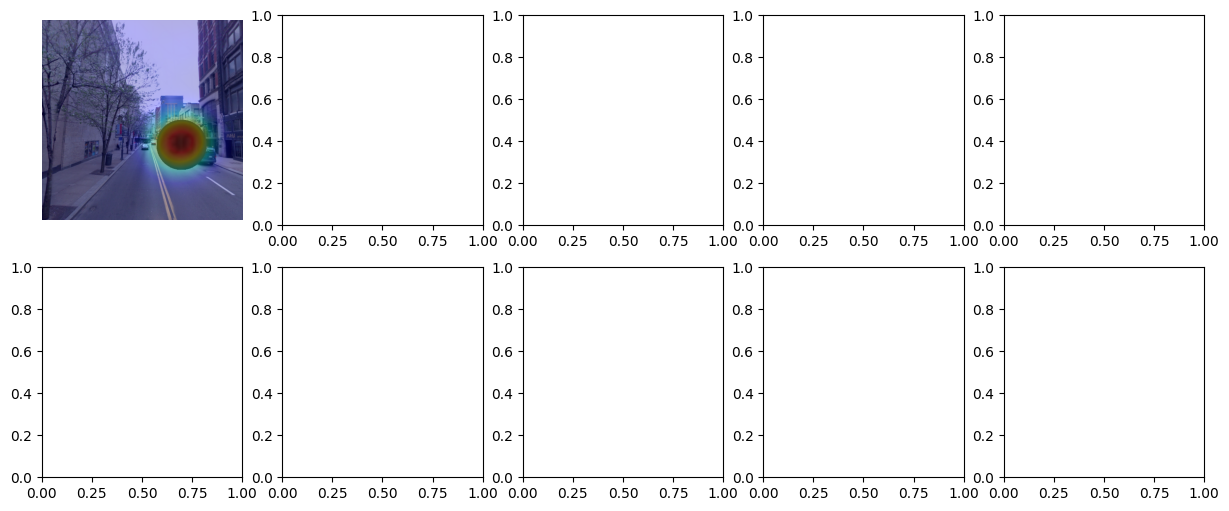

In [46]:
import matplotlib.pyplot as plt

# assume masklist is a list of 10 images (e.g., numpy arrays or PIL images)

fig, axs = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows, 5 columns, figure size (width, height)

for i, ax in enumerate(axs.flat):
    ax.imshow(masklist[i])  # display the image
    ax.axis('off')  # remove axis ticks and labels

plt.tight_layout()  # adjust layout so plots don't overlap
plt.show()


In [52]:
radius = 64
testimage = np.zeros((512,512))

In [53]:
bell = create_gaussian_bell(512, 64)
add_gaussian_bell_to_image(testimage,256,256,1,512,64,bell)

In [54]:
testimage = testimage[radius:-radius, radius:-radius]


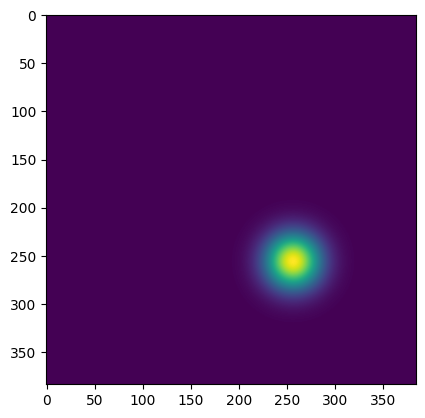

In [55]:
plt.imshow(testimage)

In [88]:
mask_test = duration_distance_weighted_density_mask_gaussian([(128,128)],[1],size=((256,256)),bell_scale=1.2e-1)[0]
mask_test_2 = duration_distance_weighted_density_mask_gaussian([(128,128)],[1],size=((256,256)),bell_scale=1.2e-2)[0]
mask_test_3 = duration_distance_weighted_density_mask_gaussian([(128,128)],[1],size=((256,256)),bell_scale=1.2e-3)[0]
mask_test_4 = duration_distance_weighted_density_mask_gaussian([(128,128)],[1],size=((256,256)),bell_scale=1.2e-4)[0]


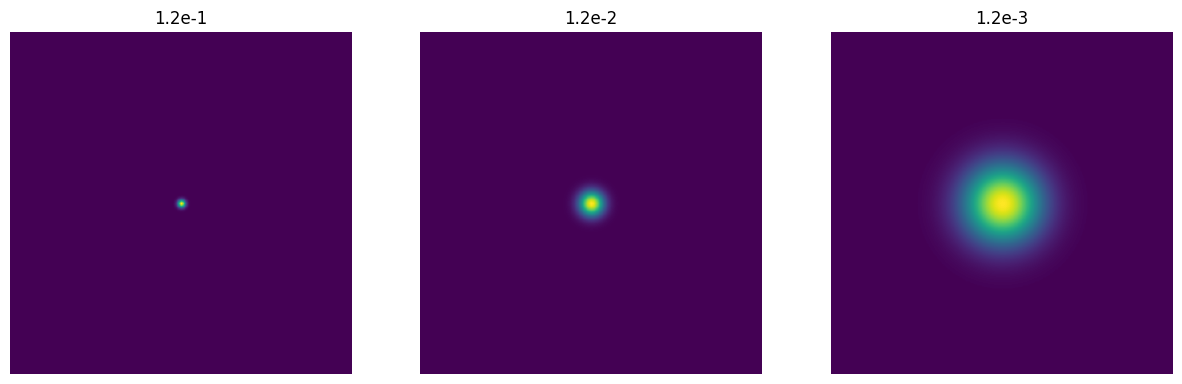

In [89]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(mask_test)
axs[0].set_title('1.2e-1')
axs[0].axis('off')

axs[1].imshow(mask_test_2)
axs[1].set_title('1.2e-2')
axs[1].axis('off')

axs[2].imshow(mask_test_3)
axs[2].set_title('1.2e-3')
axs[2].axis('off')

plt.show()


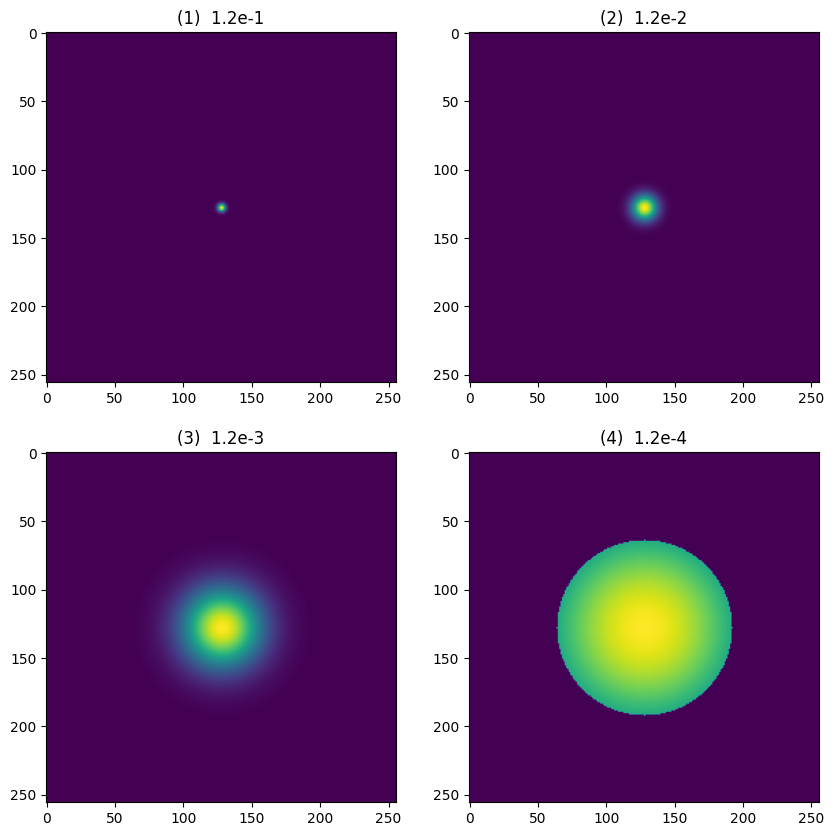

In [93]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].imshow(mask_test)
axs[0, 0].set_title('(1)  1.2e-1')
#axs[0, 0].axis('off')

axs[0, 1].imshow(mask_test_2)
axs[0, 1].set_title('(2)  1.2e-2')
#axs[0, 1].axis('off')

axs[1, 0].imshow(mask_test_3)
axs[1, 0].set_title('(3)  1.2e-3')
#axs[1, 0].axis('off')

axs[1, 1].imshow(mask_test_4)
axs[1, 1].set_title('(4)  1.2e-4')
#axs[1, 1].axis('off')

plt.show()


In [95]:
print(1.2e-3)

0.0012


In [100]:
print(np.exp(1.2e-3))

1.0012007202880864


In [110]:
print(np.exp(1.2e-3))

1.0012007202880864


In [120]:
current_image = Image.open(IMAGES_PATH + "00001/000005.png")
current_image_tensor = transform_test(current_image)
#print(imagename, class_to_dataset_class_dict[image_class])
# These values are only used for the example pictures, the pipeline values are below them.
file = open("data/auswertung/resnet50/ig/test/" + "00001/000005" + ".pkl", "rb")
attribs = pickle.load(file)
mask_raw = ig_fixpoints(attribs,fixpoint_nums=128,scale = 1e-3)
mask = normalize_image(F.interpolate(torch.Tensor(mask_raw).reshape(1,1,224,224),(512,512),mode = "bilinear").squeeze().squeeze().numpy())
image = np.copy(current_image)
#overlay_image = (mask_on_image(normalize_image(mask),normalize_image(image),alpha=0.3)*255).astype(np.uint8)
mask_raw = ig_fixpoints(attribs,fixpoint_nums=128,scale = 1e-1)
mask_2 = normalize_image(F.interpolate(torch.Tensor(mask_raw).reshape(1,1,224,224),(512,512),mode = "bilinear").squeeze().squeeze().numpy())
mask_raw = ig_fixpoints(attribs,fixpoint_nums=128,scale = 1e-2)
mask_3 = normalize_image(F.interpolate(torch.Tensor(mask_raw).reshape(1,1,224,224),(512,512),mode = "bilinear").squeeze().squeeze().numpy())
mask_raw = ig_fixpoints(attribs,fixpoint_nums=128,scale = 1e-4)
mask_4 = normalize_image(F.interpolate(torch.Tensor(mask_raw).reshape(1,1,224,224),(512,512),mode = "bilinear").squeeze().squeeze().numpy())


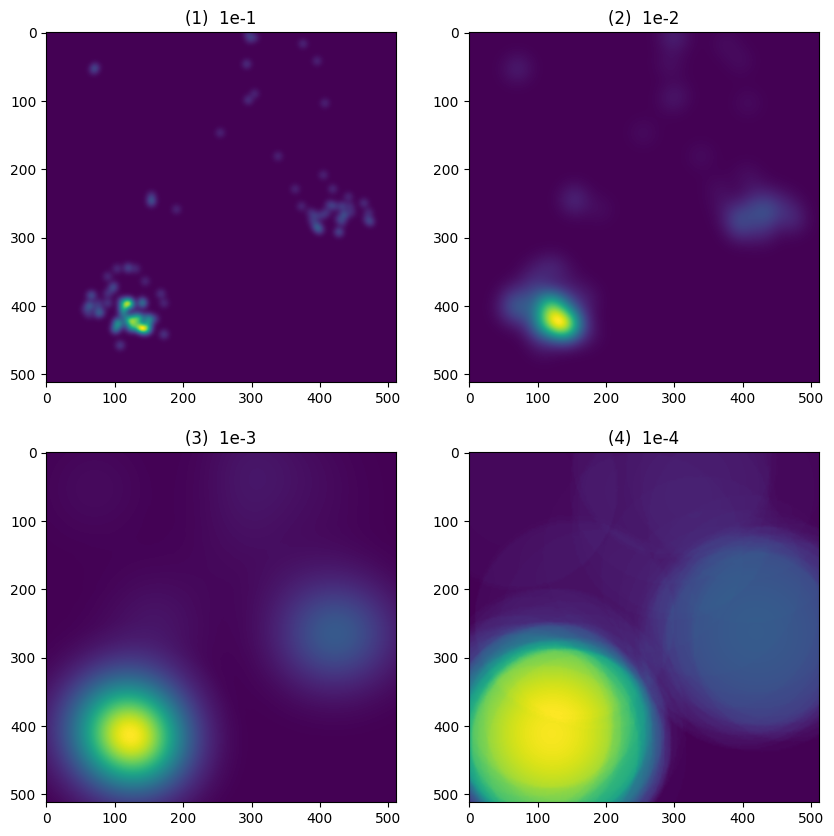

In [121]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].imshow(mask_2)
axs[0, 0].set_title('(1)  1e-1')
#axs[0, 0].axis('off')

axs[0, 1].imshow(mask_3)
axs[0, 1].set_title('(2)  1e-2')
#axs[0, 1].axis('off')

axs[1, 0].imshow(mask)
axs[1, 0].set_title('(3)  1e-3')
#axs[1, 0].axis('off')

axs[1, 1].imshow(mask_4)
axs[1, 1].set_title('(4)  1e-4')
#axs[1, 1].axis('off')

plt.show()
